# Comparative Analysis of SARIMAX and NNARX in forecasting Inflation

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import pmdarima as pm
import shap

import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv("Combined data.csv")
df.head()

,Year,Inflation,Temparature
0,1975-Feb,13.47,19.6
1,1975-Mar,12.85,20.8
2,1975-Apr,12.71,19.3
3,1975-May,12.56,18.1
4,1975-Jun,12.53,16.6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         600 non-null    object 
 1   Inflation    600 non-null    float64
 2   Temparature  395 non-null    float64
dtypes: float64(2), object(1)
memory usage: 14.2+ KB


In [7]:
df.isnull().sum()

Year             0
Inflation        0
Temparature    205
dtype: int64

In [9]:
df.rename(columns={"Temparature" : "Temperature"},inplace=True)
df.head()

,Year,Inflation,Temperature
0,1975-Feb,13.47,19.6
1,1975-Mar,12.85,20.8
2,1975-Apr,12.71,19.3
3,1975-May,12.56,18.1
4,1975-Jun,12.53,16.6


In [11]:
df["Temperature"] = df["Temperature"].fillna(df["Temperature"].mean())
df.isnull().sum()

Year           0
Inflation      0
Temperature    0
dtype: int64

In [13]:
df["Month"] = pd.to_datetime(df["Year"].astype(str))
df.head()

,Year,Inflation,Temperature,Month
0,1975-Feb,13.47,19.6,1975-02-01
1,1975-Mar,12.85,20.8,1975-03-01
2,1975-Apr,12.71,19.3,1975-04-01
3,1975-May,12.56,18.1,1975-05-01
4,1975-Jun,12.53,16.6,1975-06-01


In [15]:
df= df.set_index("Month")
df.head()

,Year,Inflation,Temperature
Month,,,
1975-02-01,1975-Feb,13.47,19.6
1975-03-01,1975-Mar,12.85,20.8
1975-04-01,1975-Apr,12.71,19.3
1975-05-01,1975-May,12.56,18.1
1975-06-01,1975-Jun,12.53,16.6


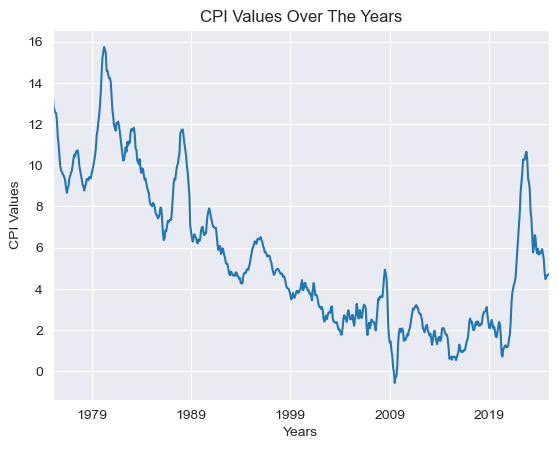

In [17]:
df["Inflation"].plot()
plt.title("CPI Values Over The Years")
plt.xlabel("Years")
plt.ylabel("CPI Values")
plt.show()

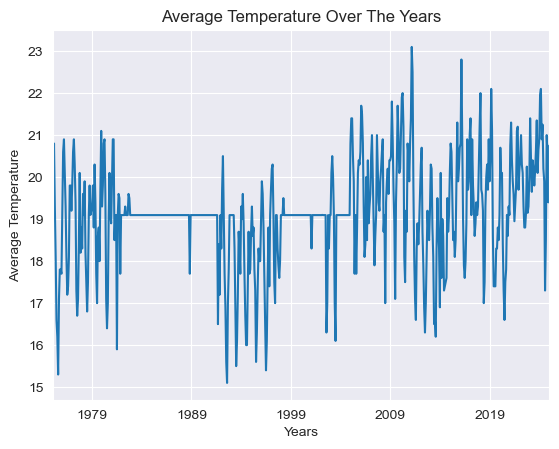

In [17]:
df["Temperature"].plot()
plt.title("Average Temperature Over The Years")
plt.xlabel("Years")
plt.ylabel("Average Temperature")
plt.show()

# EDA

#
1. Stationarity test

In [19]:
series_1 = df['Inflation'] 
def adf_for_cpi():
    results_1= adfuller(series_1, autolag='AIC')
    print('ADF Statistic: %f' % results_1[0])
    print('p-value: %f' % results_1[1])
    print(f'Number of Lags: {results_1[2]}')
    print(f'Observations used: {results_1[3]}')
    for key, value in results_1[4].items():
        print('Critical Value (%s): %.3f' % (key, value))
        
    if  results_1[1] < 0.05:
        print("\n\nCPI values are stationary")
    else:
        print("\n\nCPI values not stationary")

adf_for_cpi() 

ADF Statistic: -1.922530
p-value: 0.321538
Number of Lags: 15
Observations used: 584
Critical Value (1%): -3.442
Critical Value (5%): -2.867
Critical Value (10%): -2.569


CPI values not stationary


In [21]:
series_2= df["Temperature"]
def adf_for_cpi():
    results_2= adfuller(series_2, autolag='AIC')
    print('ADF Statistic: %f' % results_2[0])
    print('p-value: %f' % results_2[1])
    print(f'Number of Lags: {results_2[2]}')
    print(f'Observations used: {results_2[3]}')
    for key, value in results_2[4].items():
        print('Critical Value (%s): %.3f' % (key, value))
        
    if  results_2[1] < 0.05:
        print("\n\nAverage temperature values are stationary")
    else:
        print("\n\nAverage temperature values not stationary")

adf_for_cpi() 

ADF Statistic: -2.618008
p-value: 0.089332
Number of Lags: 13
Observations used: 586
Critical Value (1%): -3.442
Critical Value (5%): -2.866
Critical Value (10%): -2.569


Average temperature values not stationary


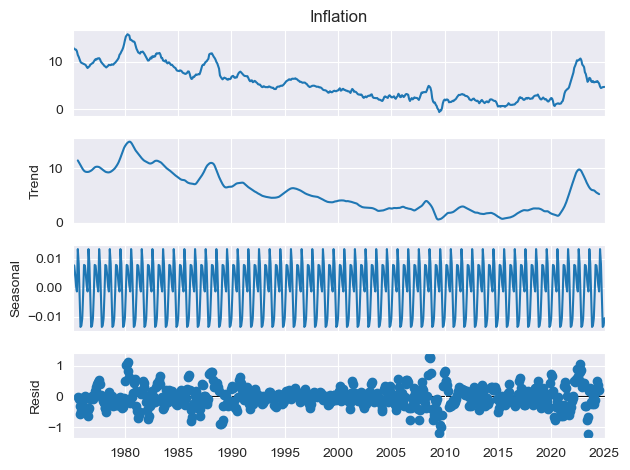

In [23]:
decomposition = seasonal_decompose(df['Inflation'], period=12)
decomposition.plot()
plt.show()

In [27]:
# Applying differencing  twice on CPI values since the CPI values has both Trend and seasonality (Not 100% sure)
df["Inflation_differenced"] = df["Inflation"].diff()  
df["Inflation_differenced"] = df["Inflation"].diff(12)
df.head(10)

,Year,Inflation,Temperature,Inflation_differenced
Month,,,,
1975-02-01,1975-Feb,13.47,19.6,NaN
1975-03-01,1975-Mar,12.85,20.8,NaN
1975-04-01,1975-Apr,12.71,19.3,NaN
1975-05-01,1975-May,12.56,18.1,NaN
1975-06-01,1975-Jun,12.53,16.6,NaN
1975-07-01,1975-Jul,12.18,16.2,NaN
1975-08-01,1975-Aug,11.40,15.3,NaN
1975-09-01,1975-Sep,11.01,17.1,NaN
1975-10-01,1975-Oct,10.49,17.8,NaN


In [29]:
df.isnull().sum()

Year                      0
Inflation                 0
Temperature               0
Inflation_differenced    12
dtype: int64

In [31]:
series_3 = df['Inflation_differenced'].dropna() 
def adf_for_cpi():
    results_1= adfuller(series_3, autolag='AIC')
    print('ADF Statistic: %f' % results_1[0])
    print('p-value: %f' % results_1[1])
    print(f'Number of Lags: {results_1[2]}')
    print(f'Observations used: {results_1[3]}')
    for key, value in results_1[4].items():
        print('Critical Value (%s): %.3f' % (key, value))
        
    if  results_1[1] < 0.05:
        print("\n\nCPI values are stationary")
    else:
        print("\n\nCPI values not stationary")

adf_for_cpi() 

ADF Statistic: -6.630193
p-value: 0.000000
Number of Lags: 16
Observations used: 571
Critical Value (1%): -3.442
Critical Value (5%): -2.867
Critical Value (10%): -2.569


CPI values are stationary


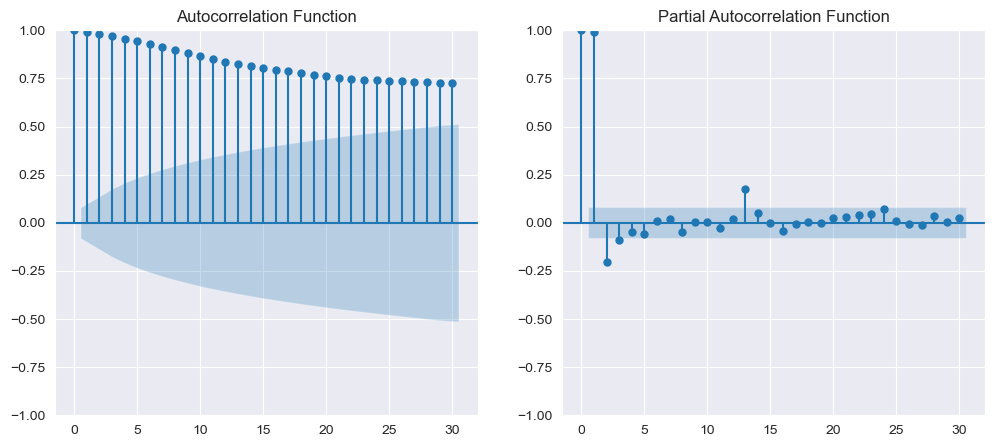

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))

plt.subplot(121)
plot_acf(df["Inflation"], lags=30, ax=plt.gca())  
plt.title("Autocorrelation Function")

plt.subplot(122)
plot_pacf(df["Inflation"], lags=30, ax=plt.gca()) 
plt.title("Partial Autocorrelation Function")


plt.show()




In [33]:
# Since the values from the field that  wanna use are stationary, i'll proceed to fitting the Arimax Model 
X = df["Temperature"]
y = df["Inflation"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=False)

print(f"X_train set shape: {X_train.shape}")
print(f"y_train set shape: {y_train.shape}")
print(f"X_test set shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train set shape: (480,)
y_train set shape: (480,)
X_test set shape: (120,)
y_test shape: (120,)


In [35]:
y_train.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 480 entries, 1975-02-01 to 2015-01-01
Series name: Inflation
Non-Null Count  Dtype  
--------------  -----  
480 non-null    float64
dtypes: float64(1)
memory usage: 7.5 KB


In [37]:
y_test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 120 entries, 2015-02-01 to 2025-01-01
Series name: Inflation
Non-Null Count  Dtype  
--------------  -----  
120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


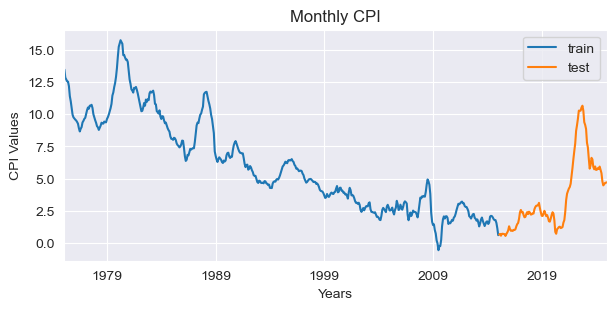

In [39]:
end_train = '2015-01-01 23:59:59'
data_train = y.loc[:end_train]
data_test  = y.loc[end_train:]

data_train.index = pd.to_datetime(data_train.index)
data_test.index = pd.to_datetime(data_test.index)

fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly CPI')
plt.xlabel("Years")
plt.ylabel("CPI Values")
ax.legend()

# SARIMAX

In [41]:
# This determines the number of non seasonal differences ,d, required to make the series stationary.  
model_autoarima = pm.auto_arima(
    y_train,
    start_p=0, start_q=0,
    test = "adf",
    max_p=5, max_q=5,
    m=12,
    d=None,
    seasonal=True,
    start_P=0,
    D=1, 
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    exogenous= X_train)
print(model_autoarima.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1727.509, Time=2.36 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1818.134, Time=0.25 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=418.416, Time=2.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.98 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1826.667, Time=0.18 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=635.214, Time=0.37 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=285.733, Time=6.04 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=223.749, Time=15.26 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.12 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=12.31 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=12.28 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.61 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=239.401, Time=16.00 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=13.57 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=inf, T

In [45]:
model_autoarima.params()

intercept   -0.012259
ar.L1        0.968066
ar.S.L12    -0.711346
ar.S.L24    -0.655226
ma.S.L12    -0.645545
sigma2       0.083824
dtype: float64

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
 
#Fit SARIMAX with values provided by auto_arima
model = SARIMAX(
    y_train,
    exog=X_train,  
    order=(1, 0, 0),
    seasonal_order=(2, 1, 1, 12),
   )
arimax_results = model.fit(disp=False)

n_steps = len(X_test)
forecast = arimax_results.forecast(steps=n_steps, exog=X_test)

In [49]:
arimax_results.params

Temperature    0.036038
ar.L1          0.999142
ar.S.L12      -0.706355
ar.S.L24      -0.513467
ma.S.L12      -0.997896
sigma2         0.075176
dtype: float64

#

Therefore our equation will be given by:

$$
Y_t = -0.0123 + 0.9991 Y_{t-1} - 0.7066 Y_{t-12} - 0.9979 \varepsilon_{t-12} + 0.0360 X_t + \varepsilon_t
$$

**Where:**

- \\( Y_t \\): Predicted inflation at time \\( t \\)
- \\( Y_{t-1} \\): Previous month’s inflation (AR(1) term)
- \\( Y_{t-12} \\): Inflation from the same month last year (seasonal AR terms)
- \\( \varepsilon_{t-12} \\): Seasonal MA lag (12-month error term)
- \\( X_t \\): Temperature at time \\( t \\) 
- \\( \beta = 0.0360 \\): Coefficient indicating the influence of temperature on inflation
- \\( \varepsilon_t \\): White noise (random error) at time \\( t \\)


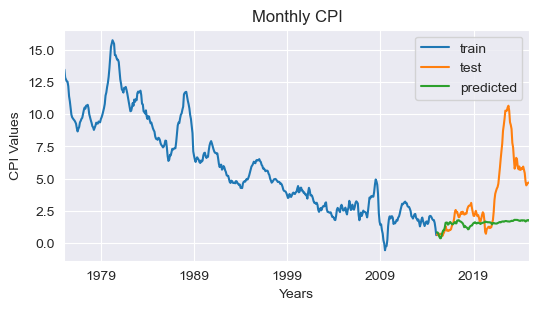

In [51]:
fig, ax=plt.subplots(figsize=(6,3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
forecast.plot(ax=ax,label= 'predicted')
ax.set_title('Monthly CPI')
plt.xlabel("Years")
plt.ylabel("CPI Values")
ax.legend()

In [53]:
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

MAE: 2.2816
RMSE: 3.3871
MSE: 11.4722


# Tuning the ARIMAX model to obtain  The best parameter

In [59]:
import itertools

# Define parameter grid (adjust ranges based on your data)
param_grid = {
    'p': [0, 1, 2],        # AR order
    'd': [0, 1],            # Differencing
    'q': [0, 1, 2],         # MA order
    'P': [0, 1],            # Seasonal AR
    'D': [0, 1],            # Seasonal differencing
    'Q': [0, 1],            # Seasonal MA
    's': [12],              
    'trend': ['n', 'c']     # Trend options
}

best_aic = np.inf
best_params = {}
best_model = None

# Grid search implementation
for params in itertools.product(*param_grid.values()):
    p, d, q, P, D, Q, s, trend = params
    
    try:
        seasonal_order = (P, D, Q, s)
        model = SARIMAX(endog=y_train,
                        exog=X_train,
                        order=(p, d, q),
                        seasonal_order=seasonal_order,
                        trend=trend,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        results = model.fit(disp=False)
        
        # Update best model if improved
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = {
                'order': (p, d, q),
                'seasonal_order': seasonal_order,
                'trend': trend
            }
            best_model = results
            
        print(f"Tried {params} - AIC: {results.aic:.2f}")
        
    except Exception as e:
        print(f"Failed for {params}: {str(e)}")
        continue

print("\nBest Parameters:", best_params)
print("Best AIC:", best_aic)

# Evaluate on test set
if best_model:
    # Generate predictions
    forecast = best_model.get_forecast(
        steps=len(X_test),
        exog=y_test
    )
    
    # Calculate MSE
    predictions = forecast.predicted_mean
    mse = mean_squared_error(y_test, predictions)
    print(f"\nTest MSE: {mse:.4f}")
    
else:
    print("No valid model found during grid search")

Tried (0, 0, 0, 0, 0, 0, 12, 'n') - AIC: 2604.89
Tried (0, 0, 0, 0, 0, 0, 12, 'c') - AIC: 2592.48
Tried (0, 0, 0, 0, 0, 1, 12, 'n') - AIC: 2146.94
Tried (0, 0, 0, 0, 0, 1, 12, 'c') - AIC: 2134.26
Tried (0, 0, 0, 0, 1, 0, 12, 'n') - AIC: 1820.43
Tried (0, 0, 0, 0, 1, 0, 12, 'c') - AIC: 1812.49
Tried (0, 0, 0, 0, 1, 1, 12, 'n') - AIC: 1708.50
Tried (0, 0, 0, 0, 1, 1, 12, 'c') - AIC: 1668.22
Tried (0, 0, 0, 1, 0, 0, 12, 'n') - AIC: 1792.75
Tried (0, 0, 0, 1, 0, 0, 12, 'c') - AIC: 1788.99
Tried (0, 0, 0, 1, 0, 1, 12, 'n') - AIC: 1721.25
Tried (0, 0, 0, 1, 0, 1, 12, 'c') - AIC: 1707.51
Tried (0, 0, 0, 1, 1, 0, 12, 'n') - AIC: 1736.16
Tried (0, 0, 0, 1, 1, 0, 12, 'c') - AIC: 1725.57
Tried (0, 0, 0, 1, 1, 1, 12, 'n') - AIC: 1716.28
Tried (0, 0, 0, 1, 1, 1, 12, 'c') - AIC: 1647.07
Tried (0, 0, 1, 0, 0, 0, 12, 'n') - AIC: 1999.57
Tried (0, 0, 1, 0, 0, 0, 12, 'c') - AIC: 1942.12
Tried (0, 0, 1, 0, 0, 1, 12, 'n') - AIC: 1625.67
Tried (0, 0, 1, 0, 0, 1, 12, 'c') - AIC: 1540.22
Tried (0, 0, 1, 0, 1

In [61]:
# Fitting The model using best parameters
import warnings
warnings.filterwarnings("ignore")
 
#Fit SARIMAX with values provided by auto_arima
model_1 = SARIMAX(
    y_train,
    exog=X_train,  
    order=(1,1,0),
    seasonal_order=(1,0,1,12),
    trend = "c"
   )
arimax_results_1 = model_1.fit(disp=False)

n_steps = len(X_test)
forecast_1 = arimax_results_1.forecast(steps=n_steps, exog=X_test)

In [64]:
arimax_results_1.params

intercept     -0.010747
Temperature    0.001851
ar.L1          0.573674
ar.S.L12      -0.066256
ma.S.L12      -0.803760
sigma2         0.033761
dtype: float64

#
Therefore our equation after using the best parameters will be given by:

$$
Y_t = -0.0107 + 0.9991 Y_{t-1} - 0.7066 Y_{t-12}  - 0.9979 \varepsilon_{t-12} + 0.0019 X_t + \varepsilon_t
$$

**Where:**

- \\( Y_t \\): Predicted inflation at time \\( t \\)
- \\( Y_{t-1} \\): Previous month’s inflation (AR(1) term)
- \\( Y_{t-12} \\): Inflation from the same month last year (seasonal AR terms)
- \\( \varepsilon_{t-12} \\): Seasonal MA lag (12-month error term)
- \\( X_t \\): Temperature at time \\( t \\) 
- \\( \beta = 0.0019 \\): Coefficient indicating the influence of temperature on inflation
- \\( \varepsilon_t \\): White noise (random error) at time \\( t \\)

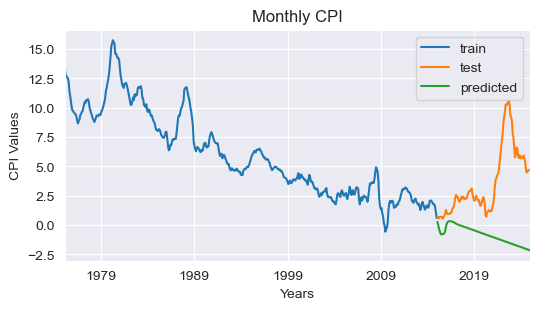

In [66]:
fig, ax=plt.subplots(figsize=(6,3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
forecast_1.plot(ax=ax,label= 'predicted')
ax.set_title('Monthly CPI')
plt.xlabel("Years")
plt.ylabel("CPI Values")
ax.legend()

In [68]:
mse = mean_squared_error(y_test, forecast_1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast_1)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

MAE: 4.4571
RMSE: 5.5597
MSE: 30.9105


# Fitting NNARX Model

In [70]:
target = df['Inflation'].asfreq('MS').ffill()  
exog = df['Temperature'].asfreq('MS').ffill()   

lags = 3 
X, y = [], []

for i in range(lags, len(target)):
    # Exogenous features (lags)
    exog_window = exog.iloc[i-lags:i][::-1].values.flatten()
    
    # Target variable (lags)
    target_window = target.iloc[i-lags:i][::-1].values
    
    # Combine features
    combined_features = np.concatenate([exog_window, target_window])
    X.append(combined_features)
    y.append(target.iloc[i])  # Next value to predict

X = np.array(X)
y = np.array(y)

split = int(0.8 * len(y))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#NNARX
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train,
                  epochs=200,
                  batch_size=32,
                  validation_split=0.2,
                  verbose=1)

# Evaluate
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MSE: {test_loss:.4f}")

sample_idx = -10  # Last 10th sample in test set
sample_input = X_test[sample_idx].reshape(1, -1)
prediction = model.predict(sample_input)[0][0]
actual = y_test[sample_idx]

print(f"\nPrediction Example:")
print(f"Input: {sample_input[0]}")
print(f"Predicted: {prediction:.2f} | Actual: {actual:.2f}")


Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 61.6456 - val_loss: 4.8804
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 52.8285 - val_loss: 3.9095
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 47.3099 - val_loss: 2.9394
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 45.6851 - val_loss: 1.9140
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 37.3174 - val_loss: 1.1051
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 29.6959 - val_loss: 1.1609
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 21.6387 - val_loss: 3.1599
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.6324 - val_loss: 7.6999
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.1023 - val_loss: 13.2039
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8886 - val_loss: 15.6364
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.5831 - val_loss: 14.1049
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━

# 
The above model NNARX(3,3), ( AR(3) and X(3) )
This is because we are using lag 3.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 


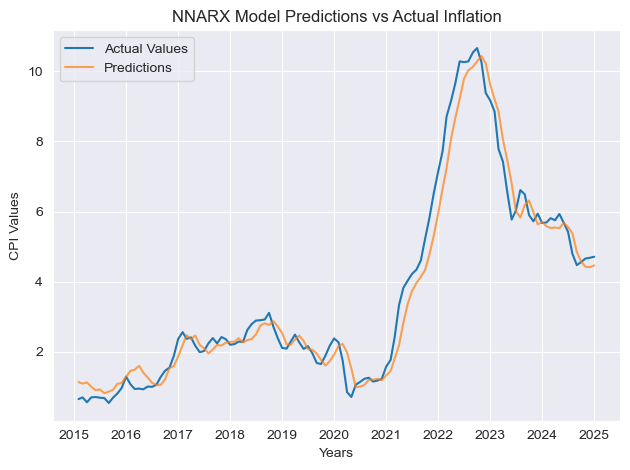

In [72]:
#Correct time Index
full_time_index = target.index[lags:]  # This aligns with your X and y
time_index_test = full_time_index[split:]  # Only the part for the test set

# predictions
predictions = model.predict(X_test).flatten()

# Plot
plt.plot(time_index_test, y_test, label='Actual Values')
plt.plot(time_index_test, predictions, label='Predictions', alpha=0.7)
plt.title('NNARX Model Predictions vs Actual Inflation')
plt.xlabel('Years')
plt.ylabel('CPI Values')
plt.legend()
plt.tight_layout()
plt.show()


In [76]:
#
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

MAE: 0.3748
RMSE: 0.4971
MSE: 0.2471


In [78]:

for i, layer in enumerate(model.layers):
    weights, biases = layer.get_weights()
    print(f"\nLayer {i + 1}:")
    print(f"Weights shape: {weights.shape}")
    print(weights)
    print(f"Biases shape: {biases.shape}")
    print(biases)



Layer 1:
Weights shape: (6, 64)
[[ 0.23785456  0.3383669   0.07687849  0.04337192  0.2176753  -0.08512454
   0.2338347  -0.18439281 -0.1663678   0.18956177 -0.24142724  0.05310429
   0.3675653  -0.16166037  0.14302671 -0.23197274  0.2209342  -0.23590298
   0.2503964   0.36901546 -0.20317946  0.14040715  0.03292734  0.03702003
   0.2005663   0.253614    0.20413576  0.354968    0.18307708  0.33944926
  -0.07475516 -0.14554362  0.37554178  0.22590005 -0.11395121  0.2118758
   0.05414101 -0.23793393  0.20032376  0.10541078  0.00882447  0.29801878
   0.08747917  0.25104728  0.17122354 -0.11794461 -0.10792509  0.16506271
  -0.23377943  0.05298753  0.21184026  0.32068112  0.12348063 -0.1513459
  -0.08921544  0.12641743 -0.03209433 -0.06421018 -0.07501593 -0.15440144
   0.18515334 -0.2622755   0.14316685 -0.1595962 ]
 [ 0.32490578 -0.07292158  0.24582933 -0.16113009 -0.06192946 -0.02654822
   0.24337746  0.22852743  0.25403658  0.24202166 -0.17562646  0.32207125
   0.29923147  0.18337885 -0.0

#
From our model the NNARX equation will be given by:
i
$$
Y_t = 0.05796389 + \sum_{j=1}^{n_h} w^{(2)}_j \cdot f\left( \sum_{i=1}^{n_x} w^{(1)}_{ji} \cdot x_i(t) + b^{(1)}_j \right)
$$

**where:**

- $Y_t$ is the predicted Inflation at time $t$  
- $x_i(t)$ is the $i$-th input feature at time $t$  
- $w^{(1)}_{ji}$ is the weight connecting input $i$ to hidden neuron $j$  
- $b^{(1)}_j$ is the bias for hidden neuron $j$  
- $f(\cdot)$ is the ReLU activation function applied at the hidden layer  
- $w^{(2)}_j$ is the weight from hidden neuron $j$ to the output neuron  
- $b^{(2)} = 0.05796389$ is the trained output bias  
- $n_x$ is the number of input features  
- $n_h$ is the number ofdden neurons
er of hidden neuronsof hidden neurons
n neurons.
he equation is fully specified.


In [82]:
#tuning randomly 
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

def build_model_1(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units1', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    
    model.add(Dense(hp.Int('units2', min_value=16, max_value=128, step=16),
                    activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = RandomSearch(
    build_model_1,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='nnarx_tuning_params_2',
    project_name='inflation_prediction_final_1'
)

tuner.search(X_train, y_train, epochs=100, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 39s]
val_mae: 0.3285734951496124

Best val_mae So Far: 0.27649036049842834
Total elapsed time: 00h 07m 01s


# 
Tuned using 10 trials

In [84]:
# Retrieve best hyperparameters from the tuner.
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

model_2 = build_model_1(best_hp)

history = model_2.fit(X_train, y_train, epochs=100, validation_split=0.2)

test_loss, test_mae = model_2.evaluate(X_test, y_test)
print("Evaluation on test set after retraining:", test_loss, test_mae)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 34.2543 - mae: 4.8438 - val_loss: 5.2277 - val_mae: 2.0869
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.2006 - mae: 1.9586 - val_loss: 10.5466 - val_mae: 3.1576
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6691 - mae: 1.3563 - val_loss: 2.4540 - val_mae: 1.4485
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8488 - mae: 0.8033 - val_loss: 0.4913 - val_mae: 0.5221
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2786 - mae: 0.3831 - val_loss: 0.3673 - val_mae: 0.4328
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2851 - mae: 0.3968 - val_loss: 0.3812 - val_mae: 0.4360
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2438 - mae: 0.3499 - val_loss: 0.4509 - val_mae: 0.4851
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2231 - mae: 0.3452 - val_loss: 0.4426 - val_mae: 0.4751
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - 

In [86]:
for i, layer in enumerate(model_2.layers):
    weights, biases = layer.get_weights()
    print(f"\nLayer {i + 1}:")
    print(f"Weights shape: {weights.shape}")
    print(weights)
    print(f"Biases shape: {biases.shape}")
    print(biases)


Layer 1:
Weights shape: (6, 224)
[[ 0.14461024  0.12237088 -0.10408354 ... -0.09062435  0.02628501
   0.20622143]
 [ 0.07605254  0.09038503 -0.13108216 ... -0.14348571 -0.15989897
   0.2853113 ]
 [-0.14502868 -0.01838406  0.06336086 ... -0.00648864 -0.21391684
   0.2498168 ]
 [ 0.11428652 -0.00075878 -0.17861146 ... -0.11286423 -0.07494733
  -0.3933041 ]
 [ 0.23335318  0.14169385  0.08956858 ...  0.10598677  0.03988115
  -0.07202599]
 [ 0.07552481 -0.03822248  0.02685612 ...  0.08500703 -0.1024535
  -0.2673553 ]]
Biases shape: (224,)
[-2.18154266e-02 -2.56186519e-02 -5.23893572e-02 -3.64140719e-02
 -4.97015081e-02 -6.00519516e-02 -2.33470723e-02 -6.27986044e-02
 -6.00519069e-02 -6.20552339e-02 -2.32817791e-02  0.00000000e+00
  0.00000000e+00 -6.77848458e-02 -5.95001169e-02 -1.05713837e-01
 -6.43806010e-02 -8.16300139e-02 -4.76351418e-02  0.00000000e+00
  0.00000000e+00 -3.30974981e-02  1.18279713e-05  6.84480146e-02
 -4.54726480e-02 -6.99367374e-02 -5.55529259e-02 -4.97088470e-02
  0.

#
From our model the NNARX equation will be given by:

$$
Y_t = 0.08562908 + \sum_{j=1}^{n_h} w^{(2)}_j \cdot f\left( \sum_{i=1}^{n_x} w^{(1)}_{ji} \cdot x_i(t) + b^{(1)}_j \right)
$$

**where:**

- $Y_t$ is the predicted Inflation at time $t$  
- $x_i(t)$ is the $i$-th input feature at time $t$  
- $w^{(1)}_{ji}$ is the weight connecting input $i$ to hidden neuron $j$  
- $b^{(1)}_j$ is the bias for hidden neuron $j$  
- $f(\cdot)$ is the ReLU activation function applied at the hidden layer  
- $w^{(2)}_j$ is the weight from hidden neuron $j$ to the output neuron  
- $b^{(2)} = 0.08562908$ is the trained output bias  
- $n_x$ is the number of input features  
- $n_h$ is the number of hidden neurons

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


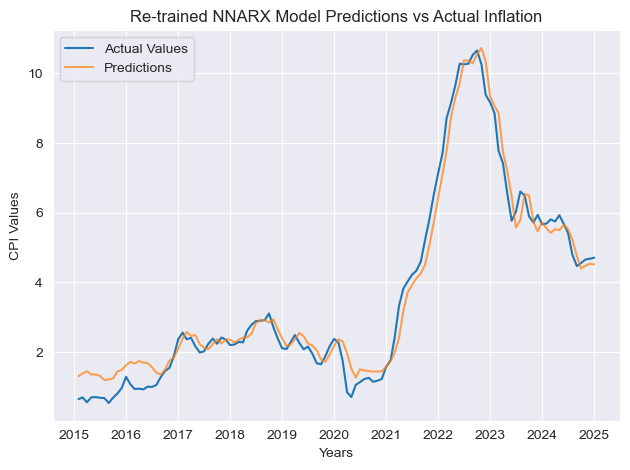

In [88]:
##Forecasting using the re-trained model 
#Time Index
full_time_index = target.index[lags:]  # This aligns with your X and y
time_index_test = full_time_index[split:]  # Only the part for the test set

# predictions
predictions_1 = model_2.predict(X_test).flatten()

# Plot
plt.plot(time_index_test, y_test, label='Actual Values')
plt.plot(time_index_test, predictions_1, label='Predictions', alpha=0.7)
plt.title('Re-trained NNARX Model Predictions vs Actual Inflation')
plt.xlabel('Years')
plt.ylabel('CPI Values')
plt.legend()
plt.tight_layout()
plt.show()

In [90]:
mse = mean_squared_error(y_test, predictions_1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions_1)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

MAE: 0.3528
RMSE: 0.4441
MSE: 0.1972
